<a href="https://colab.research.google.com/github/tyukei/AI/blob/master/report3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題1
scikit-learnの toy datasets (https://scikit-learn.org/stable/datasets/toy_dataset.html#toy-datasets) のいずれかから正解なしデータを作成し、適切な教師なし学習問題を設定せよ。そのうえで学習を行い、結果を示すPythonコードを提出せよ。なお、irisデータおよびdiabetesデータに対するクラスタリングは対象外とする。

# 下準備

まず、ライブラリーを読み込む

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture

## sklearn.datasets.load_wine
toy datasetsからload_wineを選択した。
ワインを識別するデータセットである

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine



説明変数は13種類ある。
1. alcohol アルコール濃度
2. malic_acid リンゴ酸
3. ash 灰
4. alcalinity_of_ash 灰のアルカリ成分
5. magnesium マグネシウム
6. total_phenols 総フェノール類量
7. flavanoids フラボノイド（ポリフェノールの一種）
8. nonflavanoid_phenols 非フラボノイドフェノール類
9. proanthocyanins プロアントシアニジン（ポリフェノールの一種）
10. color_intensity 色の強さ
11. hue 色合い
12. od280/od315_of_diluted_wines ワインの希釈度合い
13. proline プロリン（アミノ酸の一種）

目的変数はワインの品種である
14. ワインの品種

データを読み込む。

head()で上位５つを表示することができる。

確かに13種の説明変数があることがわかる

In [58]:
wine = load_wine()
X = pd.DataFrame(wine['data'],columns=wine['feature_names'])
display(X.iloc[:,:].head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


データに欠損値(null)がないか確認する。

欠損値の有無は 'isnull' メソッドで確認できる

Falseのとき欠損値はなく、データはすべて数値が入っていることになる

In [59]:
print(X.isnull().any(axis=0))

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool


今回はすべてFalseであったため、データの補充はしない。

もし欠損値があれば、各説明変数の平均値や中央値などで補う手法をとる

ちなみに、正解ラベル(今回であれば、ワインのタイプ)は以下のようにして得ることができる。

しかし、今回は教師なし学習のデータであるため、この値を用いない。

In [60]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

クラスタリング結果のプロットを関数にする

In [61]:
def result_plot(X, y):
  ''' 
  Xは2次元に限定、yは各データのクラスタ番号
  '''
  for t in set(y):
    plt.scatter(X[y==t,0], X[y==t,1])
  plt.legend(set(y))

# 学習の実装

## 階層的クラスタリング
クラスタリングには階層的と非階層的の２種類がある

最も似ているグループをまとめるボトムアップと
最も離れているグループを分けるトップダウンの２通りのやり方がある。

AgglomerativeClusteringを用いて階層的クラスタリングを行う。クラスタ数が3になったところで処理を止める。

特徴量は特徴１(alcohol )と特徴２(malic_acid)にする

In [62]:
X = wine.data[:,0:2]

In [63]:
ac = AgglomerativeClustering(n_clusters=3)
ac.fit(X)

AgglomerativeClustering(n_clusters=3)

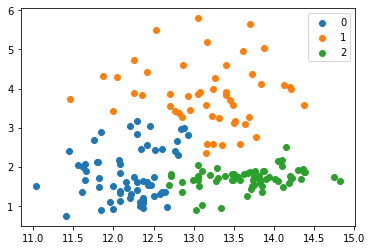

In [64]:
result_plot(X, ac.labels_)

## 非階層クラスタリング

次に非階層的クラスタリングを行う。

代表的なものにk-meansクラスタリングがある。

k-means クラスタリングは、ある点をクラスタの中心とし、

その中心と各点の距離を計算する。

各点で一番近いクラスタに割り当てる

今回はKMeansを用いて分割最適化クラスタリングを行う。クラスタ数3は予め与えておく必要がある。

In [65]:
km = KMeans(n_clusters = 3,init='random',random_state=3)
km.fit(X)

KMeans(init='random', n_clusters=3, random_state=3)

散布図をプロットして結果を確認する。

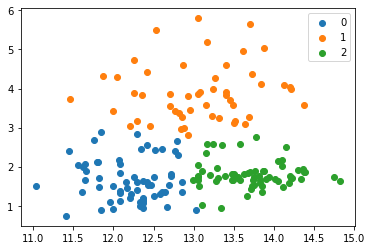

In [66]:
result_plot(X, km.labels_)

# 考察



### 階層的クラスタリングと非階層クラスタリングについて

クラスタリングのプロット結果を見比べると、
およその分類分けは一致している。

しかし、よく見てみると、階層的クラスタリングでは、
クラスタリングのタイプ２のものはx軸が13より小さいところもふくまれているが、
非階層的クラスタリングの場合、x軸が13より小さい点は含まれていない。

また、階層的クラスタリングでは、クラスタリングのタイプ２のものが、y軸が2より大きい点は含まれていないが、非階層的クラスタリングでは、2より大きい点が含まれている。

このように若干の違いがあった。

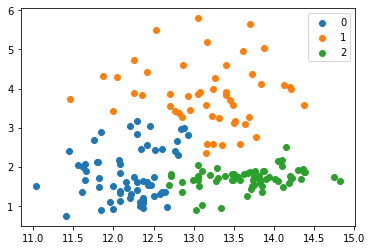

In [67]:
result_plot(X, ac.labels_) #階層的クラスタリング

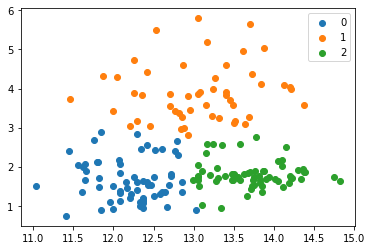

In [68]:
result_plot(X, km.labels_) #非階層的クラスタリング

階層的クラスタリングではデータ同士の距離を調べ、
グループ化を行う。

一方で、非階層的クラスタリングでは、一点中心を決め、
中心と点の距離からグループ化を行う。

そのため、若干の差が出たと考えられる。

しかし、大きくことなることはなく、もしどちらか一方が
よい精度をとったとき、もう一方の学習法も大きく精度は落ちることはなく
使用できると考えられる

### 階層的クラスタリングについて

類似度(距離の計算方法)はAgglomerativeClusteringの引数linkageで指定できる。

可能な値は'ward', 'complete', 'average', 'single' で、デフォルトは 'ward'である。

ウォード法（Ward Linkage）

ウォード法は、すべてのクラスター内の差の2乗の合計を最小化する。

せっかくなので、別のパラメータで実験を行う。

完全リンク法（Complete Linkage）

クラスターのペアの観測間の最大距離を最小化する。

completeのときの結果は以下になる

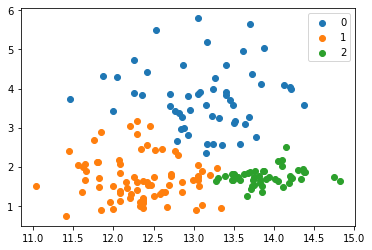

In [69]:
ac1 = AgglomerativeClustering(linkage='complete', n_clusters=3)
ac1.fit(X)
result_plot(X, ac1.labels_)

平均法（Average Linkage）

すべての観測間の距離の平均を最小化する。

averageのときの結果は以下になる

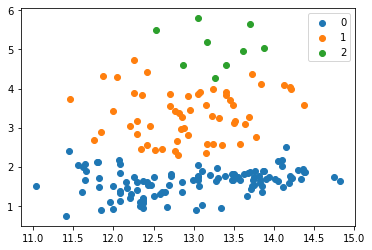

In [70]:
ac2 = AgglomerativeClustering(linkage='average', n_clusters=3)
ac2.fit(X)
result_plot(X, ac2.labels_)

単リンク法 （Single Linkage）

クラスターのペアの最も近い観測間の距離を最小化する。

singleのときの結果は以下になる

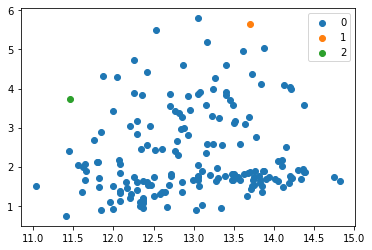

In [71]:
ac3 = AgglomerativeClustering(linkage='single', n_clusters=3)
ac3.fit(X)
result_plot(X, ac3.labels_)

計算方法がことなるので、結果は異なるものになった。

一方で、ウォード法と完全リンク法は似た形となった。

ノイズや外れ値、データの計算時間などから計算方法を変えると有効なのではないかと考えられる。

### 非階層的クラスタリングについて

k-means方のデメリットでは、各クラスタの中心によって、
結果は左右される点である。

各クラスをランダムに選ぶときは```init='randam'```とし、
集合の中心を選ぶアルゴリズムを用いるときは```init='k-means++```
とする。

せっかくなので、パラメータを調整して、実験を行う。



In [72]:
km1 = KMeans(n_clusters = 3,init='k-means++',random_state=3)
km1.fit(X)

KMeans(n_clusters=3, random_state=3)

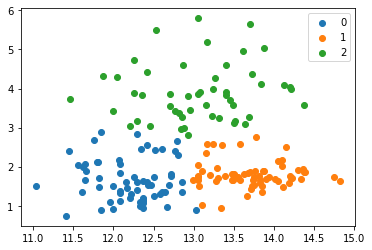

In [73]:
result_plot(X, km1.labels_)

１、２点クラスタリングの違いはあるものの、
目立った違いは見つからなかった。

初期値の中心点で結果は変わらない理由は他にあるのではないかと思いさらに調査した。

パラメータの一つに```n_init```がある。これで、初期値の点を複数回設定することができる。

デフォルトでは10となっており、ランダムであろうとk-means++であろうと、
複数回初期値が設定されているので違いが見えなかったと考えた。

そこで、```n_init=1```で実験を行った。

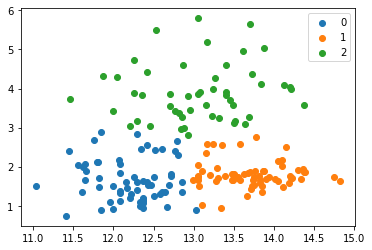

In [74]:
km2 = KMeans(n_clusters = 3,init='k-means++',n_init =1,random_state=3)
km2.fit(X)
result_plot(X, km2.labels_)

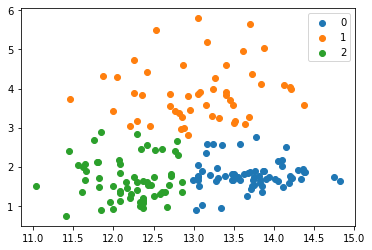

In [75]:
km3 = KMeans(n_clusters = 3,init='random',n_init =1,random_state=3)
km3.fit(X)
result_plot(X, km3.labels_)

```n_init=1```
にしたところ、
大きく変わることもなく、
また、
```init='random'```
```init='k-means++'```
の違いも視覚的には判断できなかった。

データ量が少なかったり、外れ値やノイズが小さいことなどで、
目立った違いは見られなかったかもしれないが、
この程度のデータは違いは見られなかったことがわかった。


# 課題2
教師なし学習の結果を評価する方法についてまとめたレポートを作成せよ。議論の妥当性を示すPythonによるコードも示すこと。
参考
scikit-learn user guide 2.3.10. Clustering performance evaluation
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

### 視覚的評価
まず視覚的に評価を行う

以下は正解ラベルのプロット結果である

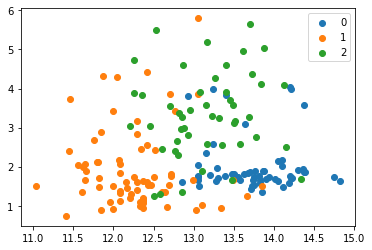

In [76]:
result_plot(X, wine.target)

以下は階層的クラスタリングのプロットの結果である

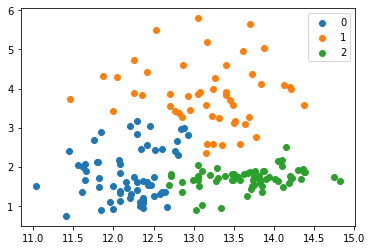

In [77]:
result_plot(X,ac.labels_)

以下は非階層的クラスタリングのプロットの結果である。

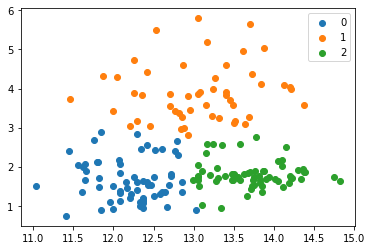

In [78]:
result_plot(X,km.labels_)

正解ラベルのプロットを見ると、
x軸が12.5から13の間でクラスタリング番号が複数交じり合っている。

一方で、教師なし学習させた結果では、あるy軸で境界線が引けるように交じりあっておらず、正解ラベルと一致していない部分が見える。

他の部分も同様に正解ラベルは複雑に交じりあっているが、
学習させた結果は単純に境界線が引けそうにクラスタリングがされているものであった。

そこから階層的クラスタリングと非階層的クラスタリングはともにおおよそクラスタリングはできているが、正答率は100パーセントや90パーセント以上以上ではなさそうと視覚的に判断できる。

一方で、階層的クラスタリングと非階層的クラスタリングではどちらが正答率が高いかは視覚的には判断ができない。

### 数量的評価
[2.3.10.1. Rand index](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
を参考に評価を行う

まずライブラリーを読み込む


In [79]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

次に正解ラベルと出力データを与え
ランド指数でクラスリング間の類似度を計算する

また、調整されていないランド指数 ```rand_score``` と調整ランド指数```adjust_rand_score```がある。
どちらも1に近いほどクラスリング間の類似度が高く、０に近いほど類似度が低い。

正答率は```accuracy_score```を用いる

### 階層的クラスタリングの評価

In [80]:
labels_true = wine.target
ac_pred = ac.labels_
print(f"rand_score:{metrics.rand_score(labels_true, ac_pred)}")
print(f"adjusted_rand_score:{metrics.adjusted_rand_score(labels_true, ac_pred)}")
print(f"accuracy_score:{accuracy_score(labels_true, ac_pred)}")

rand_score:0.7382085951882181
adjusted_rand_score:0.41319890870525655
accuracy_score:0.07865168539325842


```rand_score```は0.73で類似度は高いことがわかる。
一方で、```adjust_rand_score```は0.41と低く類似度はそこまで高くないことがわかる。

また正答率は0.07であり視覚的に評価したときよりも正答率が低いと考えられる。
正答ラベルと学習結果のクラスタリング番号に違いがあるためだと考えられる。
そこでクラスタリング番号修正し再度評価を行う。

In [87]:
adjust_label_true=np.array(list(range(0,len(wine.target))))
for num in range(len(wine.target)):
  if wine.target[num] == 0:
    adjust_label_true[num] = 2
  elif wine.target[num] == 1:
    adjust_label_true[num] = 0
  elif wine.target[num] == 2:
    adjust_label_true[num] = 1

print(adjust_label_true)


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


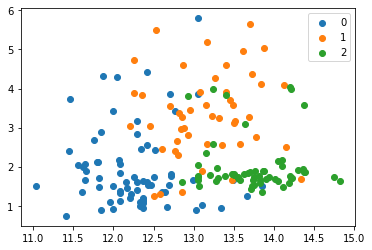

In [88]:
result_plot(X, adjust_label_true)

In [90]:
ac_pred = ac.labels_
print(f"rand_score:{metrics.rand_score(adjust_label_true, ac_pred)}")
print(f"adjusted_rand_score:{metrics.adjusted_rand_score(adjust_label_true, ac_pred)}")
print(f"accuracy_score:{accuracy_score(adjust_label_true, ac_pred)}")

rand_score:0.7382085951882181
adjusted_rand_score:0.41319890870525655
accuracy_score:0.7528089887640449


```rand_score```と```adjusted_rand_score```はクラスタリング番号を変更する前と変わらず同じ値であった。
一方で正答率は0.75と上昇しており、視覚的評価からの正答率とほぼ一致している。

ここから、ランド指数はクラスタリング番号関わらず類似度を評価できる計算方法だともわかる。

### 非階層的クラスタリングの評価

In [91]:
km_pred = km.labels_
print(f"rand_score:{metrics.rand_score(labels_true, km_pred)}")
print(f"adjusted_rand_score:{metrics.adjusted_rand_score(labels_true, km_pred)}")
print(f"accuracy_score:{accuracy_score(adjust_label_true, km_pred)}")

rand_score:0.7622040246302292
adjusted_rand_score:0.46698426576379515
accuracy_score:0.7808988764044944


```rand_score```は0.76で類似度は高いことがわかる。
一方で、```adjust_rand_score```は0.46と低く類似度はそこまで高くないことがわかる。
正答率は0.78であった。

### 階層的クラスタリングと非階層的クラスタリングについて

上記の結果をまとめると以下のようになった

||  階層的クラスタリング |  非階層的クラスタリング  |
|---           | ----   | ----   |
|ランド指数    |  0.74  |  0.76  |
|調整ランド指数|  0.41  |  0.47  |
|正答率        |  0.75  |  0.78  |

ランド指数、調整ランド指数、正答率ともに非階層的クラスタリングのほうが良い結果となった。